In [17]:
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
import os
from nltk import flatten
import scipy.stats as st
import math
import random

In [18]:
from ipynb.fs.defs.DifferentStations import prev_event, process_times, A_ii, A_ij, excitation_j, diff_comp, diff_log_likelihood, thres_fun, kappa_fun, ecdf, get_station_index

We implement some functions from SE (single station) and SE (multiple stations)).

In [19]:
def hawkes_comp(t, times, beta, theta, lambda_b):
    ratio = beta/theta
    ind = prev_event(times, t)
    second_sum = 0
    
    if ind != 0:
        second_sum = ratio * np.sum(np.exp(-theta*(t - times[0:ind])) - 1)
    comp= lambda_b*t - second_sum 
    
    return comp

In [20]:
def hawkes_log_likelihood(times, beta, theta, lambda_b): 
    ratio = beta/theta
    A = np.zeros(len(times))
    T = times[-1]
    
    for i in range(1, len(times)):
        A[i] = np.exp(-theta*(times[i] - times[i-1]))*(1+A[i-1])
    
    first_sum = np.sum(np.log(lambda_b + beta*A))
    second_sum = ratio * np.sum(np.exp(-theta*(T - times)) - 1)
    res = first_sum + second_sum - lambda_b*T
    
    return res

In [21]:
station_data = pd.read_csv("./santander_locations.csv")
loc_codes = list(station_data['Station.Id'].to_numpy())
all_times = {}

for i in range(808):
    loc = loc_codes[i]
    path = f"./dep/Station{loc}"
    data_files = os.listdir(path)

    bike = {file: pd.read_csv(path + '/' + file)
             for file in data_files}  

    for names in bike.keys():
        del bike[names]["Unnamed: 0"]
    
    times = {}

    for names in bike.keys():
        if names != '.DS_Store':
            df = bike[names]
            df = df['start_t']
            times[names] = df.values.tolist()
    
    times_list = np.array(sorted(flatten(list(times.values()))))
    all_times[loc] = times_list
    
loc_codes0 = loc_codes

In [22]:
list(bike.keys())[0]

'235_07Oct2020-13Oct2020.csv'

We use a train/test split ratio of 0.75, taking the first 12 weeks as training data, and the rest as test data. We read and split train/test sets.

In [23]:
station_data = pd.read_csv("./santander_locations.csv")
loc_codes = list(station_data['Station.Id'].to_numpy())
train_times = {}
test_times = {}

for i in range(808):
    loc = loc_codes[i]
    path = f"./sortdep/Station{loc}"
    data_files = os.listdir(path)

    bike = {file: pd.read_csv(path + '/' + file)
             for file in data_files}  

    for names in bike.keys():
        del bike[names]["Unnamed: 0"]
    
    train = {}
    test = {}
    week_list = list(bike.keys())
    n = len(week_list)
    
    for j in range(n):
        names = week_list[j]
        if names != '.DS_Store' and j < 12:
            df = bike[names]
            df = df['start_t']
            train[names] = df.values.tolist()
        elif names != '.DS_Store' and j >= 12:
            df = bike[names]
            df = df['start_t']
            test[names] = df.values.tolist()
             
    train_list = np.array(sorted(flatten(list(train.values()))))
    test_list = np.array(sorted(flatten(list(test.values()))))
    train_times[loc] = train_list
    test_times[loc] = test_list
    
loc_codes0 = loc_codes

We also read the geodesic file that contains geodesic distances between stations.

In [24]:
geo_df= pd.read_csv('./geodesic.csv')
del geo_df["Unnamed: 0"]

dist_arr = np.zeros(len(loc_codes))

In [25]:
loc_codes = loc_codes0
len(dist_arr)

808

In [26]:
ks_train_hawkes = []
ks_test_hawkes = []
ks_train_spatio = []
ks_test_spatio = []

Victoria Station

We do some preprocessing of time data.

In [229]:
sid = 268
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.5 miles to select nearby stations.

In [230]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

11
11
[148, 161, 167, 177, 178, 243, 268, 288, 320, 424, 826]


We obtain the time events for the stations in a neighbourhood of 0.5 miles in radius.

In [231]:
t00 = {}
t01 = {}

for loc in new_loc:
    t00[loc] = t0[loc]
    t01[loc] = t1[loc]

t00[268]

array([   394.06837819,    421.64216366,    429.84886557, ...,
       161060.65142088, 161062.39674381, 161121.55919642])

And the optimisation for SE (multiple stations).

In [232]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-4, -3, -8, 1.6], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[-3.84924511, -3.09005731, -8.45537374,  1.66464874],
       [-3.84922665, -3.09003794, -8.45528851,  1.66464125],
       [-3.84926822, -3.09005683, -8.45538095,  1.66463176],
       [-3.84921574, -3.09003521, -8.45542934,  1.66464875],
       [-3.84922875, -3.09006733, -8.45543148,  1.66465951]]), array([14571.40788557, 14571.40788557, 14571.40788558, 14571.40788563,
       14571.40788563]))
           fun: 14571.407885565552
       message: 'Optimization terminated successfully.'
          nfev: 195
           nit: 112
        status: 0
       success: True
             x: array([-3.84924511, -3.09005731, -8.45537374,  1.66464874])

In [235]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-3.8, -3.1, 1.7, -8.5], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

KeyboardInterrupt: 

We compute the KS statistics for both train and test sets.

In [ ]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [ ]:
ks0

In [236]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

In [237]:
ks1

KstestResult(statistic=0.09637437024246676, pvalue=4.1136177815450534e-10)

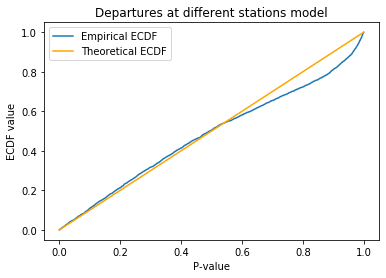

In [238]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0, label="Empirical ECDF")

plt.title("Departures at different stations model")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SE (multiple stations) for large k in kappa function, so that the model is reduced to SE (single station).

In [62]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-3, -8, -8], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[ -4.55237567, -39.98100424, -11.2378472 ],
       [ -4.55237567, -39.98095226, -11.2378472 ],
       [ -4.55237567, -39.98091893, -11.2378472 ],
       [ -4.55237567, -39.98095714, -11.2378472 ]]), array([11790.31262213, 11790.31262213, 11790.31262213, 11790.31262213]))
           fun: 11790.312622126603
       message: 'Optimization terminated successfully.'
          nfev: 368
           nit: 188
        status: 0
       success: True
             x: array([ -4.55237567, -39.98100424, -11.2378472 ])

And the KS statistics.

In [63]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

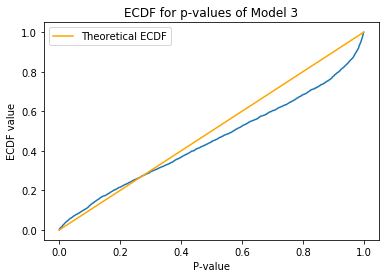

In [64]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SE (single station) model. We get the train and test time for Victoria station only.

In [239]:
t0 = train_times[268]
t1 = test_times[268]

And we compute the optimisation.

In [240]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-4.1, -6.3, -6.1], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-4.08650649, -6.28811609, -6.12061427],
       [-4.08651081, -6.28820457, -6.12061854],
       [-4.08649368, -6.28809287, -6.12057295],
       [-4.08651651, -6.28810862, -6.1205803 ]]), array([15114.06178125, 15114.06178126, 15114.06178128, 15114.0617813 ]))
           fun: 15114.061781248405
       message: 'Optimization terminated successfully.'
          nfev: 90
           nit: 47
        status: 0
       success: True
             x: array([-4.08650649, -6.28811609, -6.12061427])

And we compute the KS statistics as well as plotting the QQ plots.

In [241]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [242]:
ks2.statistic

0.11060406732788763

In [243]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

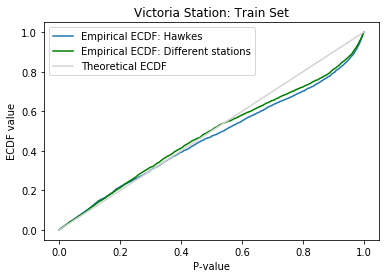

In [244]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Train Set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')
plt.legend()
plt.show()

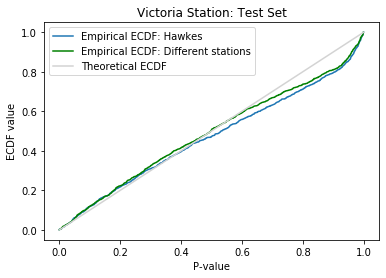

In [245]:
x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.plot(x21,y21,  label="Empirical ECDF: Hawkes")
plt.plot(x01,y01,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Test Set")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')
plt.legend()
plt.show()

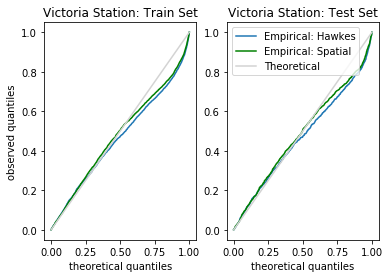

In [248]:
x2,y2 = ecdf(p_values2)
plt.subplot(1, 2, 1)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Train Set")
plt.xlabel("theoretical quantiles")
plt.ylabel("observed quantiles")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')



x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.subplot(1, 2, 2)
plt.plot(x21,y21,  label="Empirical: Hawkes")
plt.plot(x01,y01,  label="Empirical: Spatial", color='green')

plt.title("Victoria Station: Test Set")
plt.xlabel("theoretical quantiles")
plt.plot([0,1], [0,1], label="Theoretical", color='lightgray')
plt.legend()


plt.savefig('v1.pdf')
plt.show()

Waterloo Station

We do some preprocessing of time data.

In [266]:
sid = 374
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.5 miles to select nearby stations.

In [267]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

14
14
[154, 173, 197, 252, 272, 273, 334, 336, 347, 361, 374, 377, 815, 819]


We obtain the time events for the stations in a neighbourhood of 0.5 miles in radius.

In [268]:
t00 = {}
t01 = {}

for loc in new_loc:
    t00[loc] = t0[loc]
    t01[loc] = t1[loc]
    
t00.keys()

dict_keys([154, 173, 197, 252, 272, 273, 334, 336, 347, 361, 374, 377, 815, 819])

And the optimisation for SE (multiple stations).

In [158]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-4, -3, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[-3.84926669, -3.09007511, -8.45537375,  1.66464124],
       [-3.84920263, -3.09003322, -8.45534507,  1.66465546],
       [-3.849242  , -3.09008676, -8.45541233,  1.66466425],
       [-3.84923558, -3.0900144 , -8.45542272,  1.66462596],
       [-3.84924283, -3.09007275, -8.45546357,  1.66464788]]), array([14571.40788558, 14571.40788563, 14571.40788567, 14571.40788569,
       14571.40788571]))
           fun: 14571.40788558111
       message: 'Optimization terminated successfully.'
          nfev: 456
           nit: 268
        status: 0
       success: True
             x: array([-3.84926669, -3.09007511, -8.45537375,  1.66464124])

We compute the KS statistics for both train and test sets. And the QQ plots.

In [270]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [271]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

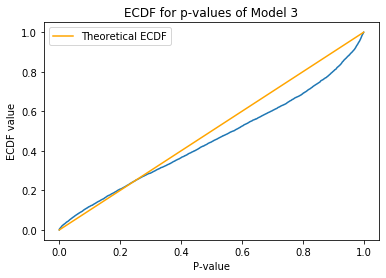

In [94]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SE (multiple stations) for large k in kappa function, so that the model is reduced to SE (single station).

In [99]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[ -4.4600117 ,  -3.89546789, -10.62337822],
       [ -4.46000851,  -3.89545638, -10.62344389],
       [ -4.46002638,  -3.8954701 , -10.62340859],
       [ -4.45999775,  -3.89544542, -10.62330309]]), array([24148.18059898, 24148.18059907, 24148.1805992 , 24148.1805992 ]))
           fun: 24148.180598984636
       message: 'Optimization terminated successfully.'
          nfev: 168
           nit: 92
        status: 0
       success: True
             x: array([ -4.4600117 ,  -3.89546789, -10.62337822])

And the KS statistics.

In [100]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

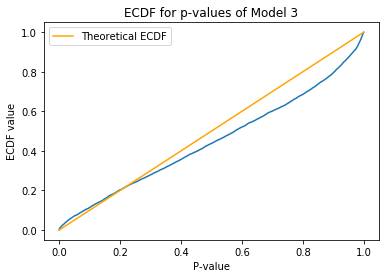

In [101]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SE (single station) model. We get the train and test time for Waterloo station only.

In [272]:
t0 = train_times[374]
t1 = test_times[374]

And we compute the optimisation.

In [273]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-3.67249437, -8.0500733 , -9.23636648],
       [-3.6724928 , -8.05014571, -9.23637637],
       [-3.67249399, -8.05016234, -9.23636872],
       [-3.67249621, -8.05007101, -9.23638705]]), array([24655.08221933, 24655.08221933, 24655.08221933, 24655.08221934]))
           fun: 24655.082219332613
       message: 'Optimization terminated successfully.'
          nfev: 287
           nit: 166
        status: 0
       success: True
             x: array([-3.67249437, -8.0500733 , -9.23636648])

And we compute the KS statistics as well as plotting the QQ plots.

In [274]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [275]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

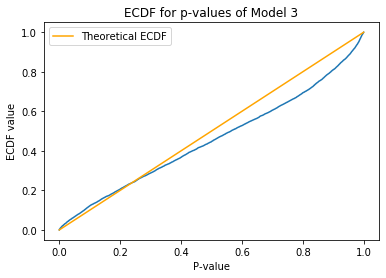

In [276]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

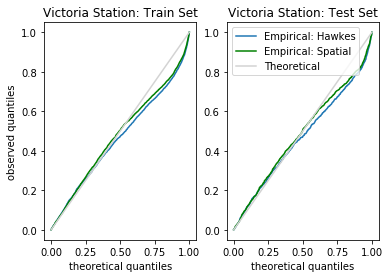

In [250]:
x2,y2 = ecdf(p_values2)
plt.subplot(1, 2, 1)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Victoria Station: Train Set")
plt.xlabel("theoretical quantiles")
plt.ylabel("observed quantiles")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')



x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.subplot(1, 2, 2)
plt.plot(x21,y21,  label="Empirical: Hawkes")
plt.plot(x01,y01,  label="Empirical: Spatial", color='green')

plt.title("Victoria Station: Test Set")
plt.xlabel("theoretical quantiles")
plt.plot([0,1], [0,1], label="Theoretical", color='lightgray')
plt.legend()

plt.savefig('v2.pdf')


Paddington Station

We do some preprocessing of time data.

In [278]:
sid = 186
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.5 miles to select nearby stations.

In [279]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

7
7
[186, 265, 279, 290, 330, 370, 408]


We obtain the time events for the stations in a neighbourhood of 0.5 miles in radius.

In [280]:
t00 = {}
t01 = {}

for loc in new_loc:
    if loc not in ind_list:
        t00[loc] = t0[loc]
        t01[loc] = t1[loc]
    
new_loc = list(t00.keys())

And the optimisation for SE (multiple stations).

In [281]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -3.85746826,  -3.99937713, -10.45439721,   1.3533935 ],
       [ -3.8574779 ,  -3.99937963, -10.45436746,   1.35339949],
       [ -3.85746976,  -3.99934598, -10.45447989,   1.3533829 ],
       [ -3.85749443,  -3.99940759, -10.45449561,   1.35339833],
       [ -3.85746423,  -3.99941385, -10.45446345,   1.35343002]]), array([20960.79889313, 20960.79889316, 20960.79889331, 20960.79889333,
       20960.79889334]))
           fun: 20960.798893131294
       message: 'Optimization terminated successfully.'
          nfev: 787
           nit: 466
        status: 0
       success: True
             x: array([ -3.85746826,  -3.99937713, -10.45439721,   1.3533935 ])

We compute the KS statistics for both train and test sets.

In [282]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [283]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

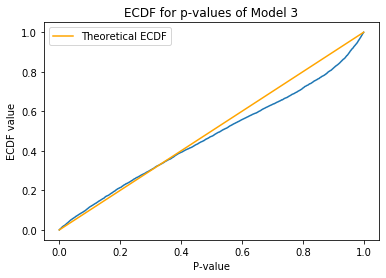

In [284]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SE (multiple stations) for large k in kappa function, so that the model is reduced to SE (single station).

In [143]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[-3.98398511, -8.36833696, -9.44918038],
       [-3.98398713, -8.36826141, -9.44917018],
       [-3.98398428, -8.36839508, -9.44917836],
       [-3.98398443, -8.36825676, -9.44917483]]), array([21467.0443917, 21467.0443917, 21467.0443917, 21467.0443917]))
           fun: 21467.044391700347
       message: 'Optimization terminated successfully.'
          nfev: 227
           nit: 126
        status: 0
       success: True
             x: array([-3.98398511, -8.36833696, -9.44918038])

And the KS statistics.

In [144]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

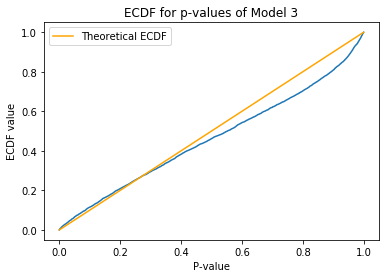

In [145]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SE (single station) model. We get the train and test time for Paddington station only.

In [146]:
t0 = train_times[186]
t1 = test_times[186]


And we compute the optimisation.

In [147]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-3.98398511, -8.36833696, -9.44918038],
       [-3.98398713, -8.36826141, -9.44917018],
       [-3.98398428, -8.36839508, -9.44917836],
       [-3.98398443, -8.36825676, -9.44917483]]), array([21467.0443917, 21467.0443917, 21467.0443917, 21467.0443917]))
           fun: 21467.044391700347
       message: 'Optimization terminated successfully.'
          nfev: 227
           nit: 126
        status: 0
       success: True
             x: array([-3.98398511, -8.36833696, -9.44918038])

And we compute the KS statistics as well as plotting the QQ plots.

In [148]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [149]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

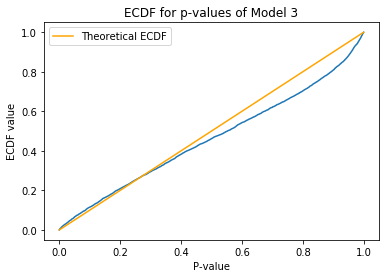

In [150]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

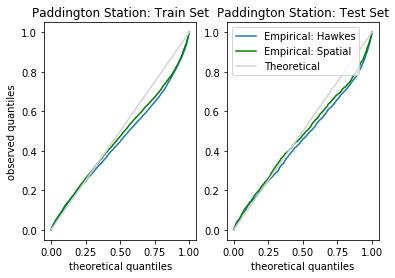

In [286]:
x2,y2 = ecdf(p_values2)
plt.subplot(1, 2, 1)
plt.plot(x2,y2,  label="Empirical ECDF: Hawkes")
plt.plot(x0,y0,  label="Empirical ECDF: Different stations", color='green')

plt.title("Paddington Station: Train Set")
plt.xlabel("theoretical quantiles")
plt.ylabel("observed quantiles")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='lightgray')



x21,y21 = ecdf(p_values21)
x01,y01 = ecdf(p_values01)
plt.subplot(1, 2, 2)
plt.plot(x21,y21,  label="Empirical: Hawkes")
plt.plot(x01,y01,  label="Empirical: Spatial", color='green')

plt.title("Paddington Station: Test Set")
plt.xlabel("theoretical quantiles")
plt.plot([0,1], [0,1], label="Theoretical", color='lightgray')
plt.legend()

plt.show()

London Bridge

We do some preprocessing of time data.

In [151]:
sid = 706
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.5 miles to select nearby stations.

In [153]:
thres = 0.5
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

7
7
[85, 269, 278, 308, 314, 321, 706]


We obtain the time events for the stations in a neighbourhood of 0.5 miles in radius.

In [155]:
t00 = {}
t01 = {}

for loc in new_loc:
    if loc not in ind_list:
        t00[loc] = t0[loc]
        t01[loc] = t1[loc]
    
new_loc = list(t00.keys())

And the optimisation for SE (multiple stations).

In [156]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -4.4362979 , -41.98665806, -11.22718008,  19.32658707],
       [ -4.4362979 , -41.98662429, -11.22718008,  19.32657299],
       [ -4.4362979 , -41.9865791 , -11.22718008,  19.32655414],
       [ -4.4362979 , -41.98657748, -11.22718008,  19.32655347],
       [ -4.4362979 , -41.98661365, -11.22718008,  19.32656855]]), array([13821.59784233, 13821.59784233, 13821.59784233, 13821.59784233,
       13821.59784233]))
           fun: 13821.597842327441
       message: 'Optimization terminated successfully.'
          nfev: 505
           nit: 272
        status: 0
       success: True
             x: array([ -4.4362979 , -41.98665806, -11.22718008,  19.32658707])

And we compute the KS statistics as well as plotting the QQ plots.

In [157]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [158]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

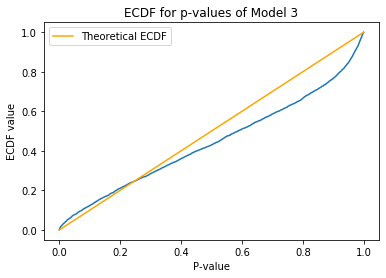

In [159]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SE (multiple stations) for large k in kappa function, so that the model is reduced to SE (single station).

In [160]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[ -4.43629791, -41.74076084, -11.22718052],
       [ -4.43629791, -41.7407555 , -11.22718052],
       [ -4.43629791, -41.74081133, -11.22718052],
       [ -4.43629791, -41.74066822, -11.22718052]]), array([13821.59784233, 13821.59784233, 13821.59784233, 13821.59784233]))
           fun: 13821.597842327441
       message: 'Optimization terminated successfully.'
          nfev: 415
           nit: 213
        status: 0
       success: True
             x: array([ -4.43629791, -41.74076084, -11.22718052])

And the KS statistics.

In [161]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

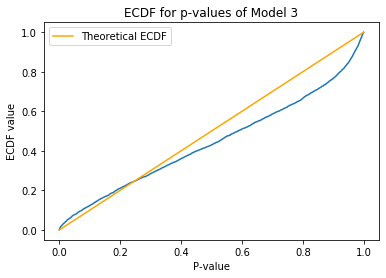

In [162]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SE (single station) model. We get the train and test time for London Bridge Station only.

In [163]:
t0 = train_times[374]
t1 = test_times[374]

And we compute the optimisation.

In [164]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-3.67249437, -8.0500733 , -9.23636648],
       [-3.6724928 , -8.05014571, -9.23637637],
       [-3.67249399, -8.05016234, -9.23636872],
       [-3.67249621, -8.05007101, -9.23638705]]), array([24655.08221933, 24655.08221933, 24655.08221933, 24655.08221934]))
           fun: 24655.082219332613
       message: 'Optimization terminated successfully.'
          nfev: 287
           nit: 166
        status: 0
       success: True
             x: array([-3.67249437, -8.0500733 , -9.23636648])

And we compute the KS statistics as well as plotting the QQ plots.

In [165]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [166]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

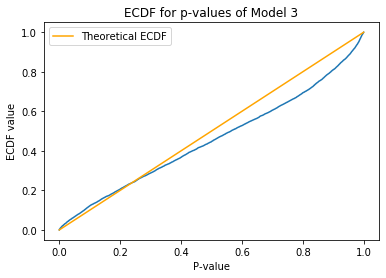

In [167]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

King's Cross

We do some preprocessing of time data.

In [171]:
sid = 798
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.4 miles to select nearby stations.

In [172]:
thres = 0.4
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

6
6
[4, 14, 70, 593, 793, 798]


We obtain the time events for the stations in a neighbourhood of 0.4 miles in radius.

In [173]:
t00 = {}
t01 = {}

for loc in new_loc:
    if loc not in ind_list:
        t00[loc] = t0[loc]
        t01[loc] = t1[loc]
    
new_loc = list(t00.keys())

And the optimisation for SE (multiple stations).

In [174]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -4.53545008, -38.78045598, -12.61983584,   3.96486705],
       [ -4.53545008, -38.78053173, -12.61983584,   3.96486705],
       [ -4.53545008, -38.78048089, -12.61983584,   3.96486705],
       [ -4.53545008, -38.78053717, -12.61983584,   3.96486705],
       [ -4.53545008, -38.78052346, -12.61983584,   3.96486705]]), array([11863.14876305, 11863.14876305, 11863.14876305, 11863.14876305,
       11863.14876305]))
           fun: 11863.148763053616
       message: 'Optimization terminated successfully.'
          nfev: 698
           nit: 397
        status: 0
       success: True
             x: array([ -4.53545008, -38.78045598, -12.61983584,   3.96486705])

We compute the KS statistics for both train and test sets.

In [175]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [176]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

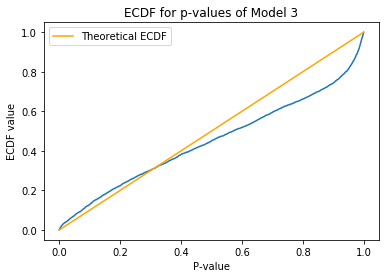

In [177]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SE (multiple stations) for large k in kappa function, so that the model is reduced to SE (single station).

In [178]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[ -4.63479887, -39.92813714, -12.02759482],
       [ -4.63479887, -39.92812801, -12.02759482],
       [ -4.63479887, -39.9280819 , -12.02759482],
       [ -4.63479887, -39.92806304, -12.02759482]]), array([11870.00028289, 11870.00028289, 11870.00028289, 11870.00028289]))
           fun: 11870.000282890436
       message: 'Optimization terminated successfully.'
          nfev: 564
           nit: 305
        status: 0
       success: True
             x: array([ -4.63479887, -39.92813714, -12.02759482])

In [179]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

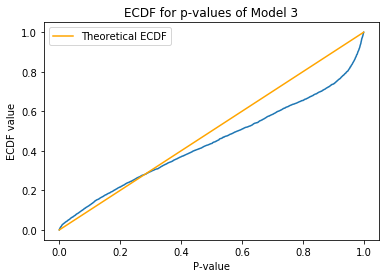

In [180]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SE (single station) model. We get the train and test time for King's Cross station only.

In [181]:
t0 = train_times[798]
t1 = test_times[798]

And we compute the optimisation.

In [182]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[ -4.63785477, -22.60185483, -12.0305487 ],
       [ -4.63785486, -22.6019466 , -12.03055077],
       [ -4.63785492, -22.60185435, -12.03055141],
       [ -4.63785496, -22.60195199, -12.03054841]]), array([15349.10245065, 15349.10245065, 15349.10245065, 15349.10245065]))
           fun: 15349.102450651326
       message: 'Optimization terminated successfully.'
          nfev: 229
           nit: 131
        status: 0
       success: True
             x: array([ -4.63785477, -22.60185483, -12.0305487 ])

And we compute the KS statistics as well as plotting the QQ plots.

In [183]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [184]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

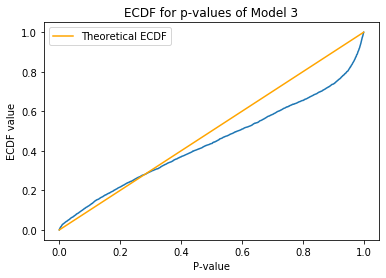

In [185]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Marylebone

We do some preprocessing of time data.

In [186]:
sid = 45
ind = get_station_index(loc_codes, sid)

t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)

#if len(ind_list) != 0:
    #loc_codes[ind_list] = -1
    #loc_codes = [i for i in loc_codes if i != -1]
    
dist_arr = geo_df[f"{ind}"].to_numpy()

And we choose a threshold of 0.4 miles to select nearby stations.

In [187]:
thres = 0.4
new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
print(len(new_loc));
print(len(new_dist));
print(new_loc)

7
7
[45, 114, 182, 201, 605, 759, 760]


We obtain the time events for the stations in a neighbourhood of 0.4 miles in radius.

In [188]:
t00 = {}
t01 = {}

for loc in new_loc:
    if loc not in ind_list:
        t00[loc] = t0[loc]
        t01[loc] = t1[loc]
    
new_loc = list(t00.keys())

And the optimisation for SE (multiple stations).

In [189]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
mle0 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2, 2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
mle0

 final_simplex: (array([[ -3.8937697 ,  -3.22549344, -12.62288785,   1.54832899],
       [ -3.84932703,  -3.19889454, -11.75186618,   1.30386401],
       [ -3.63966093,  -2.96654402, -11.09915976,   1.36434303],
       [ -3.69567122,  -2.92554209, -10.65684445,   1.46467096],
       [ -3.94910899,  -3.03065105, -10.79827322,   1.01576727]]), array([15862.41065476, 15865.35211356, 15884.19013374, 15896.60801416,
       15913.79061957]))
           fun: 15862.410654762522
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 800
           nit: 487
        status: 1
       success: False
             x: array([ -3.8937697 ,  -3.22549344, -12.62288785,   1.54832899])

We compute the KS statistics for both train and test sets.

In [190]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t00[sid]
compensator_t0 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times0 = np.diff(compensator_t0)
p_values0 = np.exp(-inter_arr_times0)
ks0 = st.kstest(p_values0, "uniform")
ks_train_spatio.append(ks0.statistic)

In [191]:
beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

t_dep = t01[sid]
compensator_t01 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

inter_arr_times01 = np.diff(compensator_t01)
p_values01 = np.exp(-inter_arr_times01)
ks1 = st.kstest(p_values01, "uniform")
ks_test_spatio.append(ks1.statistic)

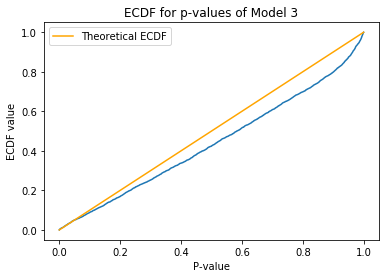

In [192]:
x0,y0 = ecdf(p_values0)
plt.plot(x0,y0)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

We could optimise SE (multiple stations) for large k in kappa function, so that the model is reduced to SE (single station).

In [193]:
op_diff_log_likelihood = lambda param, location_codes, t, dist, k, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), k, dist, i)
mle1 = op.minimize(op_diff_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, np.exp(50), sid))
mle1

 final_simplex: (array([[-4.01397488, -7.75573055, -9.23922276],
       [-4.0139704 , -7.75581278, -9.23920537],
       [-4.01397024, -7.75572847, -9.2392063 ],
       [-4.01397267, -7.75572574, -9.23919636]]), array([16080.9818064 , 16080.98180641, 16080.98180641, 16080.98180642]))
           fun: 16080.98180639662
       message: 'Optimization terminated successfully.'
          nfev: 228
           nit: 129
        status: 0
       success: True
             x: array([-4.01397488, -7.75573055, -9.23922276])

And the KS statistics.

In [194]:
beta1, theta1, lambda_b1, k1 = np.exp(mle1.x[0]), np.exp(mle1.x[0])+np.exp(mle1.x[1]), np.exp(mle1.x[2]), np.exp(10)

t_dep = t00[sid]
compensator_t1 = np.zeros(len(t_dep)+1)
for j in range(len(t_dep)):
    compensator_t1[j+1] = diff_comp(t_dep[j], new_loc, t00, beta1, theta1, lambda_b1, new_dist, k1)

inter_arr_times1 = np.diff(compensator_t1)
p_values1 = np.exp(-inter_arr_times1)

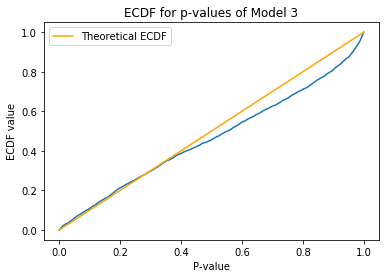

In [195]:
x1,y1 = ecdf(p_values1)
plt.plot(x1,y1)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

Now we fit the SE (single station) model. We get the train and test time for Marylebone station only.

In [196]:
t0 = train_times[45]
t1 = test_times[45]

And we compute the optimisation.

In [197]:
op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-2, -2, -2], method = 'Nelder-Mead', args=(t0,))
mle2

 final_simplex: (array([[-4.01397488, -7.75573055, -9.23922276],
       [-4.0139704 , -7.75581278, -9.23920537],
       [-4.01397024, -7.75572847, -9.2392063 ],
       [-4.01397267, -7.75572574, -9.23919636]]), array([16080.9818064 , 16080.98180641, 16080.98180641, 16080.98180642]))
           fun: 16080.98180639662
       message: 'Optimization terminated successfully.'
          nfev: 228
           nit: 129
        status: 0
       success: True
             x: array([-4.01397488, -7.75573055, -9.23922276])

And we compute the KS statistics as well as plotting the QQ plots.

In [198]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t2 = np.zeros(len(t0)+1)
for i in range(len(t0)):
    compensator_t2[i+1] = hawkes_comp(t0[i], t0, beta2, theta2, lambda_b2)

inter_arr_times2 = np.diff(compensator_t2)
p_values2 = np.exp(-inter_arr_times2)
ks2 = st.kstest(p_values2, "uniform")
ks_train_hawkes.append(ks2.statistic)

In [199]:
beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

compensator_t21 = np.zeros(len(t1)+1)
for i in range(len(t1)):
    compensator_t21[i+1] = hawkes_comp(t1[i], t1, beta2, theta2, lambda_b2)

inter_arr_times21 = np.diff(compensator_t21)
p_values21 = np.exp(-inter_arr_times21)
ks21 = st.kstest(p_values21, "uniform")
ks_test_hawkes.append(ks21.statistic)

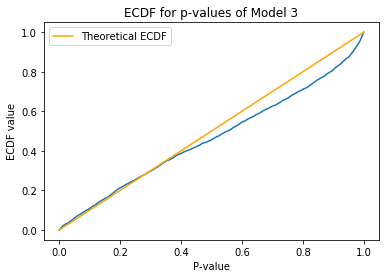

In [200]:
x2,y2 = ecdf(p_values2)
plt.plot(x2,y2)

plt.title("ECDF for p-values of Model 3")
plt.xlabel("P-value")
plt.ylabel("ECDF value")
plt.plot([0,1], [0,1], label="Theoretical ECDF", color='orange')
plt.legend()
plt.show()

For each station, we set threshold at 0.5 miles, and find a neighbourhood of nearby stations. We obtain the list of stations that does not have any nearby stations within 0.5 miles.

In [28]:
thres = 0.5
null_list = []
for k in range(808):
    sid = loc_codes[k] 
    ind = get_station_index(loc_codes, sid)
    
    if len(train_times[sid]) != 0:
        t0, ind_list = process_times(loc_codes, train_times, sid)
        t1, ind_list = process_times(loc_codes, test_times, sid)
    
    dist_arr = geo_df[f"{ind}"].to_numpy()
    new_dist, new_loc = thres_fun(dist_arr, thres, loc_codes)
    if len(new_loc) < 2:
        null_list.append(sid)
null_list

[554, 692, 783, 844]

In [29]:
sid=4
ind = get_station_index(loc_codes, sid)
t0, ind_list = process_times(loc_codes, train_times, sid)
t1, ind_list = process_times(loc_codes, test_times, sid)
    
dist_arr = geo_df[f"{ind}"].to_numpy()
df = pd.DataFrame({'col1': list(dist_arr), 'col2': list(loc_codes)})
df=df.sort_values(by=['col1'])
ser = df.iloc[:, 0]
i = ser.searchsorted(1.2, side='right')
df1 = df.iloc[:i]

For each station, we set threshold at 0.5 miles, and find a neighbourhood of nearby stations. We obtain the list of stations that does not have any nearby stations within 0.5 miles.

In [30]:
def thres_fun_new(dist, thres, loc_codes):
    new_dist = dist.copy()
    new_loc_codes = np.asarray(loc_codes).copy()
    df = pd.DataFrame({'col1': list(new_dist), 'col2': list(new_loc_codes)})
    df = df.sort_values(by=['col1'])
    
    df = pd.DataFrame({'col1': list(dist_arr), 'col2': list(loc_codes)})
    df=df.sort_values(by=['col1'])
    ser = df.iloc[:, 0]
    i = ser.searchsorted(thres, side='right')
    df1 = df.iloc[:i]
    
    return np.asarray(df1.iloc[:, 0]), np.asarray(df1.iloc[:, 1])

In [80]:
loc_list = np.unique(loc_list)
while len(loc_list) < 100: 
    sid = np.random.choice(loc_codes)
    if len(train_times[sid]) != 0 and sid not in null_list and sid not in loc_list:
        loc_list.append(sid)

In [83]:
max_t1 = 0
for i in loc_list:
    max_t1 = max(len(train_times[i]), max_t1)

max_t2 = 0
for i in loc_list:
    max_t2 = max(len(test_times[i]), max_t2)

We randomly select 100 stations, fit both SE (single stations) and SE (multiple stations), and record the KS statistics for both models.

In [84]:
#loc_list = []
thres = 0.5
train_hawkes = []
test_hawkes = []
train_spatio = []
test_spatio = []

p0 = np.zeros((max_t1+1, 100))
p1 = np.zeros((max_t2+1, 100))
p2 = np.zeros((max_t1+1, 100))
p3 = np.zeros((max_t2+1, 100))

#while len(loc_list) < 100: 
for i in range(100): 
    #sid = np.random.choice(loc_codes)
    sid = loc_list[i]
    if len(train_times[sid]) != 0 and sid not in null_list: #and sid not in loc_list:
        #loc_list.append(sid)
        #print(len(loc_list))
        print(i)
        ind = get_station_index(loc_codes, sid)

        t0, ind_list = process_times(loc_codes, train_times, sid)
        t1, ind_list = process_times(loc_codes, test_times, sid)
    
        dist_arr = geo_df[f"{ind}"].to_numpy()
    
        new_dist, new_loc = thres_fun_new(dist_arr, thres, loc_codes)
    
        new_dist = new_dist
        new_loc = new_loc
    
        t00 = {}
        t01 = {}

        for loc in new_loc:
            if loc not in ind_list:
                t00[loc] = t0[loc]
                t01[loc] = t1[loc]
    
        new_loc = list(t00.keys())
        op_diff_log_likelihood = lambda param, location_codes, t, dist, i: - diff_log_likelihood(location_codes, t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), 
                                                                                         np.exp(param[2]), np.exp(param[3]), dist, i)
        mle0 = op.minimize(op_diff_log_likelihood, x0 = [-3.8, -3.1, -8.5, 1.7], method = 'Nelder-Mead', args=(new_loc, t00, new_dist, sid))
    
        beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])

        t_dep = t00[sid]
        compensator_t0 = np.zeros(len(t_dep)+1)
        for j in range(len(t_dep)):
            compensator_t0[j+1] = diff_comp(t_dep[j], new_loc, t00, beta0, theta0, lambda_b0, new_dist, k0)

        inter_arr_times0 = np.diff(compensator_t0)
        p_values0 = np.exp(-inter_arr_times0)
        ks0 = st.kstest(p_values0, "uniform")
        train_spatio.append(ks0.statistic)
        print(ks0.statistic)
        p0[0:len(t_dep), i] = p_values0
               
        beta0, theta0, lambda_b0, k0 = np.exp(mle0.x[0]), np.exp(mle0.x[0])+np.exp(mle0.x[1]), np.exp(mle0.x[2]), np.exp(mle0.x[3])
 
        t_dep = t01[sid]
        compensator_t01 = np.zeros(len(t_dep)+1)
        for j in range(len(t_dep)):
            compensator_t01[j+1] = diff_comp(t_dep[j], new_loc, t01, beta0, theta0, lambda_b0, new_dist, k0)

        inter_arr_times01 = np.diff(compensator_t01)
        p_values01 = np.exp(-inter_arr_times01)
        ks1 = st.kstest(p_values01, "uniform")
        test_spatio.append(ks1.statistic)
        
        p1[0:len(t_dep), i] =  p_values01
        
        t0 = train_times[sid]
        t1 = test_times[sid]
        op_hawkes_log_likelihood = lambda param, t: - hawkes_log_likelihood(t, np.exp(param[0]), np.exp(param[0])+np.exp(param[1]), np.exp(param[2]))
        mle2 = op.minimize(op_hawkes_log_likelihood, x0 = [-4.1, -6.3, -6.1], method = 'Nelder-Mead', args=(t0,))
        beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

        compensator_t2 = np.zeros(len(t0)+1)
        for j in range(len(t0)):
            compensator_t2[j+1] = hawkes_comp(t0[j], t0, beta2, theta2, lambda_b2)

        inter_arr_times2 = np.diff(compensator_t2)
        p_values2 = np.exp(-inter_arr_times2)
        ks2 = st.kstest(p_values2, "uniform")
        train_hawkes.append(ks2.statistic)
        print(ks2.statistic)
        p2[0:len(t0), i] = p_values2
    
        beta2, theta2, lambda_b2 = np.exp(mle2.x[0]), np.exp(mle2.x[0]) + np.exp(mle2.x[1]), np.exp(mle2.x[2])

        compensator_t21 = np.zeros(len(t1)+1)
        for j in range(len(t1)):
            compensator_t21[j+1] = hawkes_comp(t1[j], t1, beta2, theta2, lambda_b2)

        inter_arr_times21 = np.diff(compensator_t21)
        p_values21 = np.exp(-inter_arr_times21)
        ks21 = st.kstest(p_values21, "uniform")
        test_hawkes.append(ks21.statistic)

        p3[0:len(t1), i] = p_values21

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [160]:
len(np.unique(loc_list))

100

In [163]:
p2

array([[2.04275860e-21, 0.00000000e+00],
       [8.44989304e-12, 0.00000000e+00],
       [2.29162725e-11, 0.00000000e+00],
       ...,
       [9.99975937e-01, 0.00000000e+00],
       [9.99997423e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])

We find the difference between the KS statistics of both models.

In [85]:
train_diff = np.array(train_hawkes) - np.array(train_spatio)
train_sign = np.sign(train_diff)
test_diff = np.array(test_hawkes) - np.array(test_spatio)
test_sign = np.sign(test_diff)

And find the number of stations that perform better with SE (multiple stations) model.

In [96]:
from collections import Counter
Counter(train_sign)

Counter({1.0: 84, -1.0: 16})

In [97]:
from collections import Counter
Counter(test_sign)

Counter({-1.0: 22, 1.0: 78})

The relative ks scores will be $\frac{KS_{mutual} - KS_{seven}}{KS_{mutual}}$

In [98]:
rel_train_ks = (np.array(train_hawkes) - np.array(train_spatio)) / np.array(train_hawkes)
#uni_rel_train_ks = np.unique(rel_train_ks)
rel_test_ks = (np.array(test_hawkes) - np.array(test_spatio)) / np.array(test_hawkes)
#uni_rel_test_ks = np.unique(rel_test_ks)

We now want to plot the scatter plot of station coordinates of the randomly selected 100 stations, labelling the points by the difference in their ks scores.

In [99]:
len(train_hawkes)

100

In [100]:
station_data = pd.read_csv("./santander_locations.csv")

In [101]:
#uni_loc_list = np.unique(np.array(loc_list))
d = {'loc': loc_list, 'train': rel_train_ks, 'test': rel_test_ks}
df1 = pd.DataFrame(data=d)
df1 = df1.sort_values(by=['loc'])
df1 = df1.drop_duplicates(subset=['loc'])

In [102]:
df1

,loc,train,test
0,4,0.166065,-0.036920
1,5,-0.205708,-0.116331
2,32,0.177215,0.156140
3,37,-0.135485,-0.070507
4,40,0.112259,0.098976
...,...,...,...
95,810,0.116535,0.096601
96,811,0.086758,0.063802
97,812,-0.026549,-0.044601
98,821,0.007917,0.051524


In [103]:
mask = station_data['Station.Id'].isin(loc_list)
df = station_data.loc[mask]
df['train.ks'] = list(df1['train'])
df['test.ks'] = list(df1['test'])
df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Station.Id,StationName,longitude,latitude,Easting,Northing,train.ks,test.ks
3,4,"St. Chad's Street, King's Cross",-0.120974,51.530100,530436.760,182911.990,0.166065,-0.036920
4,5,"Sedding Street, Sloane Square",-0.156876,51.493100,528051.649,178742.097,-0.205708,-0.116331
31,32,"Leonard Circus, Shoreditch",-0.084439,51.524700,532986.420,182381.310,0.177215,0.156140
35,37,"Penywern Road, Earl's Court",-0.192369,51.491600,525590.340,178509.690,-0.135485,-0.070507
38,40,"Commercial Street, Shoreditch",-0.075579,51.521300,533611.070,182016.510,0.112259,0.098976
...,...,...,...,...,...,...,...,...
778,810,"Tate Modern, Bankside",-0.098885,51.506721,532037.270,180356.310,0.116535,0.096601
779,811,"Westferry Circus, Canary Wharf",-0.027776,51.505697,536975.000,180373.000,0.086758,0.063802
780,812,"Here East North, Queen Elizabeth Olympic Park",-0.022627,51.548724,537203.027,185167.369,-0.026549,-0.044601
789,821,"Battersea Power Station, Battersea Park",-0.147702,51.483516,528714.824,177688.956,0.007917,0.051524


In [104]:
max(list(df['train.ks']))

0.47612204528174434

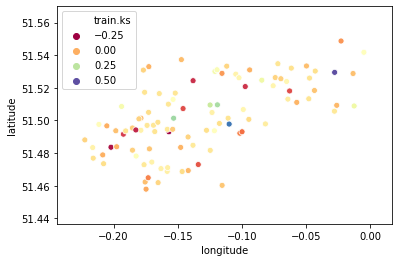

In [105]:
import seaborn as sns
sns.scatterplot('longitude', 'latitude', data=df, hue=df['train.ks'], palette="Spectral")

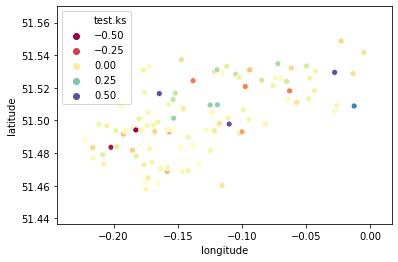

In [107]:
sns.scatterplot('longitude', 'latitude', data=df, hue=df['test.ks'], palette="Spectral")
#sns.savefig('fig1.pdf')

We plot the ks scores of each station over the log of the number of departure events at each station. 

In [108]:
dep_len_train_all = []
dep_len_test_all = []
dep_len_train_id = []
dep_len_test_id = []

for i in range(len(loc_list)):
    sid = loc_list[i]
    ind = get_station_index(loc_codes, sid)
    train_len = 0
    test_len = 0
    
    t0, ind_list = process_times(loc_codes, train_times, sid)
    t1, ind_list = process_times(loc_codes, test_times, sid)
    
    dist_arr = geo_df[f"{ind}"].to_numpy()
    
    new_dist, new_loc = thres_fun_new(dist_arr, thres, loc_codes)
    
    new_dist = new_dist
    new_loc = new_loc
    
    t00 = {}
    t01 = {}

    for loc in new_loc:
        if loc not in ind_list:
            t00[loc] = t0[loc]
            train_len += len(t00[loc])
            t01[loc] = t1[loc]
            test_len += len(t01[loc])

    dep_len_train_all.append(train_len)
    dep_len_test_all.append(test_len)

    dep_len_train_id.append(len(t00[sid]))
    dep_len_test_id.append(len(t01[sid]))
    
log_dep_train_all = np.log(np.array(dep_len_train_all))
log_dep_test_all = np.log(np.array(dep_len_test_all))
    
log_dep_train = np.log(np.array(dep_len_train_id))
log_dep_test = np.log(np.array(dep_len_test_id))

In [109]:
d1 = {'loc': loc_list, 'train.ks': rel_train_ks, 
      'test.ks': rel_test_ks, 'train.len.all': log_dep_train_all, 
      'test.len.all': log_dep_test_all, 'train.len.id': log_dep_train, 'test.len.id': log_dep_test}
df2 = pd.DataFrame(data=d1)
df2 = df2.sort_values(by=['loc'])
df2 = df2.drop_duplicates(subset=['loc'])

In [110]:
df2

,loc,train.ks,test.ks,train.len.all,test.len.all,train.len.id,test.len.id
0,4,0.166065,-0.036920,10.306282,9.198875,7.517521,6.434547
1,5,-0.205708,-0.116331,9.805654,8.747511,8.716536,7.610853
2,32,0.177215,0.156140,10.624128,9.492733,8.494743,7.346655
3,37,-0.135485,-0.070507,10.189531,9.093245,8.358197,7.195937
4,40,0.112259,0.098976,10.859114,9.734359,8.242493,7.065613
...,...,...,...,...,...,...,...
95,810,0.116535,0.096601,10.142308,9.063926,7.989899,6.978214
96,811,0.086758,0.063802,9.718903,8.585599,8.780480,7.631432
97,812,-0.026549,-0.044601,9.241548,8.013343,7.959276,6.776507
98,821,0.007917,0.051524,10.011759,8.992682,9.314070,8.195058


Scatter plot of all departure training events in the neighborhood of each station.

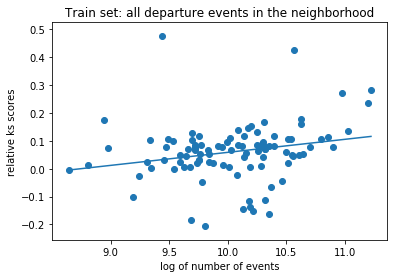

In [123]:
#sns.scatterplot('train.len', 'train.ks', data=df, hue=df['train.ks'])
x = df2['train.len.all']
y = df2['train.ks']
plt.scatter(x, y)

#a, b = np.polyfit(x, y, 1)
#plt.plot(x, a*x+b)        
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: all departure events in the neighborhood')
plt.show()

In [124]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.009913293911515143

Scatter plot of the departure train events of each station only.

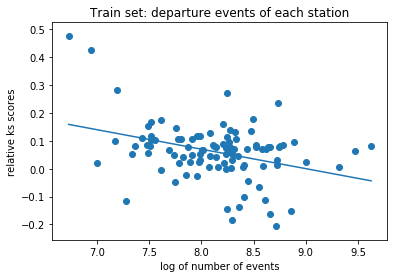

In [125]:
x = df2['train.len.id']
y = df2['train.ks']
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: departure events of each station')
plt.show()

In [126]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.009127335580408442

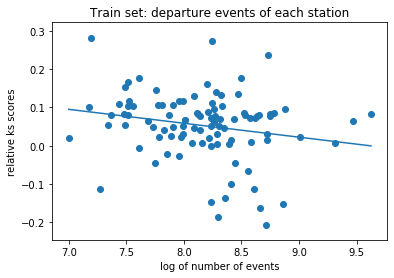

In [127]:
#Remove anomalies
indice = np.where(y.to_numpy() < 0.4)[0].tolist()
x_new = x.to_numpy()[indice]
y_new = y.to_numpy()[indice]
plt.scatter(x_new, y_new)
plt.plot(np.unique(x_new), np.poly1d(np.polyfit(x_new, y_new, 1))(np.unique(x_new)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Train set: departure events of each station')
plt.show()

Scatter plot of all departure test events in the neighbourhood of each station.

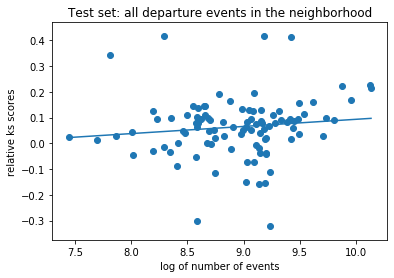

In [121]:
#sns.scatterplot('longitude', 'latitude', data=df, hue=df['test.ks'])
x = df2['test.len.all']
y = df2['test.ks']
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: all departure events in the neighborhood')
plt.show()

In [116]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.013361533054851077

Scatter plot of the departure test events of each station only.

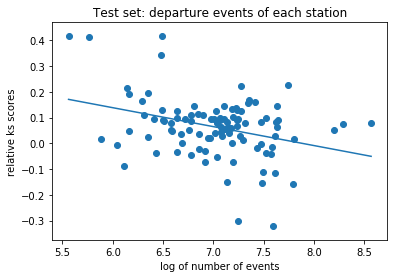

In [117]:
x = df2['test.len.id']
y = df2['test.ks']
plt.scatter(x, y)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.xlabel('log of number of events')
plt.ylabel('relative ks scores')
plt.title('Test set: departure events of each station')
plt.show()

In [118]:
yhat = np.poly1d(np.polyfit(x, y, 1))(x)
MSE = 1/len(y) * np.sum((yhat - y)**2)
MSE

0.012051243492679732

In [58]:
indice = np.argwhere(train_sign == 1).tolist()
len(indice)

success_list = []
for i in indice:
    success_list.append(loc_list[i[0]])

In [63]:
indice1 = np.argwhere(test_sign == 1).tolist()
len(indice1)

success_list1 = []
for i in indice:
    success_list1.append(loc_list[i[0]])

In [323]:
from collections import Counter
Counter(train_sign)

Counter({-1.0: 84, 1.0: 16})

We plot a boxplot for all models together.

In [ ]:
data = [train_hawkes, train_spatio, train_mutual, train_seven]
plt.boxplot(data)

plt.xticks([1, 2, 3, 4], ['SE (s)', 'SE (m)', 'SME (s)', 'SME (m)'])
plt.savefig('box.pdf')simulation for spatio component
github link